# Alodataset: Loading your vision datasets

Alodataset implements ready-to-use datasets for computer vision with the help of `aloscene` and augmented tensors to make it easy to transform and display your vision data. The list of all datasets can be found in the alodataset section in the aloception API.

## Using samples

Most proposed dataset on aloception can be built using `samples=True`. It means you can at any point try out one dataset without having the data on your disk. This is great for a quick test or to quickly try out a model.

Here is a quick example of creating datasets using samples.

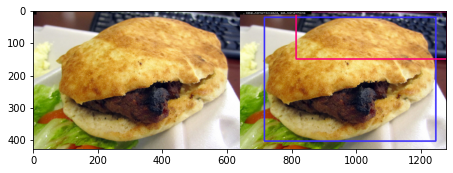

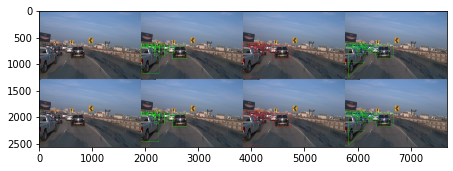

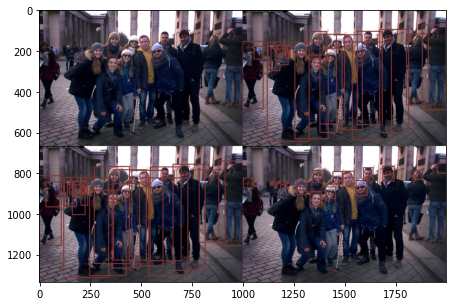

In [11]:
import alodataset

# Coco Detection Dataset
dataset = alodataset.CocoBaseDataset(sample=True)
frame = dataset.getitem(0)
frame.get_view().render()

# Waymo dataset
dataset = alodataset.WaymoDataset(sample=True)
# This dataset return multiple camera view
waymo_frame = dataset.getitem(0)["front"]
waymo_frame.get_view().render()

# Crowd Human dataset
dataset = alodataset.CrowdHumanDataset(sample=True)
crowd_frame = dataset.getitem(0)
crowd_frame.get_view().render()


<div class="alert alert-info">
**NOTE**
    
- In the above example, getting a view on the Waymo dataset display more images since the frames are made of multiple set of boxes 2d. By default, get view will plot all the sets on different view. This is the same for the HumanCrowd dataset.
    
- Since waymo is a sequence based dataset, the samples are made using with a temporal dimension. Therefore, the plot display the first (t=0) and second time step (t=1).
</div>


In [4]:
print(waymo_frame.shape, waymo_frame.names)

torch.Size([2, 3, 1280, 1920]) ('T', 'C', 'H', 'W')


## Stream loader

The provided dataset on aloception all exposed a `stream_loader()` method. It make particular sense for datasets with sequences. The method will iterate on the data without shuffling and without batch. 

Here is an example:

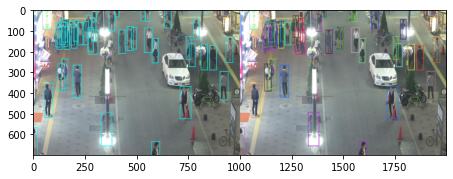

In [10]:
import alodataset

mot_dataset = alodataset.Mot17(sample=True, validation_sequences=["MOT17-05"])

for f, frames in enumerate(mot_dataset.stream_loader()):
    frames.names
    frames.get_view(
        [
            frames.boxes2d[0].get_view(frames[0], labels_set="objects_class"),
            frames.boxes2d[0].get_view(frames[0], labels_set="objects_id"),
        ],
        size=(700, 1000),
    ).render()
    break

## Train loader

The train loader is the one used for training or validation. The train_loader will return frames as batch (list of Frame). 

Having a list of frame, one might want to merge all the frame on a batch dimension, even if the frames have different size. For this usual use case, all spatial augmented tensor (frames, mask, flow...) can be concat using the `batch_list` method. All augmented tensors will be padded and will expose a `mask` property keeping track of the padded area.

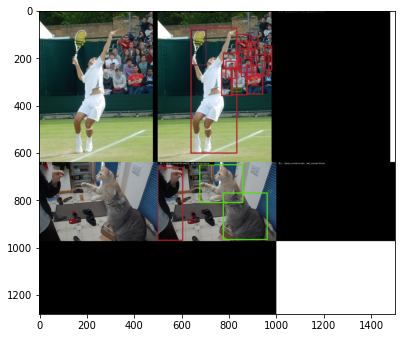

torch.Size([2, 3, 640, 500]) ('B', 'C', 'H', 'W')


In [10]:
import alodataset
import aloscene

# Coco Detection Dataset
dataset = alodataset.CocoBaseDataset(sample=True)

for frames in dataset.train_loader(batch_size=2):
    frames = aloscene.Frame.batch_list(frames)
    frames.get_view().render()
    print(frames.shape, frames.names)
    break

In the above example, the two loaded images have different size. Therefore, merging the frames on the batch  dimension will padd each frame, automaticly pad the boxes accordingly and add a `mask` (visible on the right) to keep track of the padded area.

## Using transformations

Using the transformations provided by `alodataset`, one can very simply augment its data while being sure that all data will change accordingly. For example, in the following example, cropping, flipping and resizing the frames will automaticly update the attached boxes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


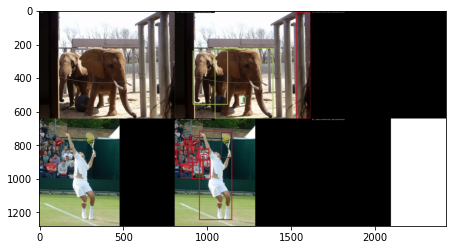

In [9]:
from alodataset import transforms as T 
import alodataset
import aloscene

def transform_fn(frame):
    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]
    frame = T.Compose(
        [
            T.RandomHorizontalFlip(),
            T.RandomSelect(
                T.RandomResizeWithAspectRatio(scales, max_size=1333),
                T.Compose(
                    [
                        T.RandomResizeWithAspectRatio([400, 500, 600]),
                        T.RandomSizeCrop(384, 600),
                        T.RandomResizeWithAspectRatio(scales, max_size=1333),
                    ]
                ),
            ),
        ]
    )(frame)
    return frame

# Coco Detection Dataset
dataset = alodataset.CocoBaseDataset(sample=True, transform_fn=transform_fn)

for frames in dataset.train_loader(batch_size=2):
    frames = aloscene.Frame.batch_list(frames)
    frames.get_view().render()
    break